# Data Preparation

data pipelines for pre-processing to prepare for training a model

course: https://learn.deeplearning.ai/courses/pytorch-fundamentals/

lesson: https://learn.deeplearning.ai/specializations/pytorch-for-deep-learning-professional-certificate/lesson/naa8i9/data-access 

goal: set up a robust data pipeline to ingest and process data for machine learning

three data management concepts:
- Access
    -- retrieving the data
- Quality
    -- correct size, format, structure
- Efficiency
    -- loading in batches given local memory constraints

In [ ]:
# imports

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


import scipy
import os
import requests
import time
import numpy as np

import matplotlib.pyplot as plt

from PIL import Image   # Python package: Pillow

import tarfile

In [2]:
# Data Access
# Build Dataset class

class OxfordFlowersDataset(Dataset):
    # setup
    # loading the data and pre-processing
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.error_log = []

        # OxfordFlowersDataset.download_dataset(root_dir)
        # TODO: just manually download files and upload to the correct directory, but how do we create the jpg files from the .tgz bundle?
        
        self.img_dir = os.path.join(root_dir, 'jpg')    # once 102flowers.tgz is unzipped, the jpg folder will be created with the unzipped images
        # print("image dir", self.img_dir)

        # load Matlab labels of Oxford dataset
        labels_mat = scipy.io.loadmat(os.path.join(root_dir, 'imagelabels.mat'))
        self.labels = labels_mat['labels'][0]-1

    # total samples
    # len(data)
    def __len__(self):
        return len(self.labels)
    
    # how to get input data and labels given index
    # e.g., data[0]
    def __getitem__(self, idx):

        try: 
            # build image filenmae
            img_name = f'image_{idx + 1:05d}.jpg'   # image names start at 1, not index 0
            img_path = os.path.join(self.img_dir, img_name)

            # load image
            image = Image.open(img_path)
            label = self.labels[idx]

            # --- further individual sample processing ---
            # check for data corruption
            image.verify()  # verify closes the file
            image = Image.open(img_path)  # reopen for transform use

            # skip tiny images
            if image.size[0] < 32 or image.size[1] < 32:
                raise ValueError(f"Image {img_name} is too small: {image.size}")

            # convert grayscale to RGB
            if image.mode != 'RGB':
                image = image.convert('RGB')

            # apply transforms that were passed in
            if self.transform:
                    image = self.transform(image)
            return image, label

        except Exception as e:
            self.error_log.append({
                  'index': idx,
                  'error': str(e),
                  'path': img_path if 'img_path' in locals() else 'unknown'
             })

            print(f"Warning: skipping corrupted image {idx}: {e}")
          
            # try next image if corrupted or any other error occurs
            next_idx = (idx + 1) % len(self)
            return self.__getitem__(next_idx)
    

    def get_error_summary(self):
        """ Review errors after training """
        if not self.error_log:
            print("No errors encountered.")
        else:
            print(f"Encountered {len(self.error_log)} errors")
            # show first 5 errors
            NUM_INITIAL_ERRORS_TO_SHOW = 5
            print(f"First {NUM_INITIAL_ERRORS_TO_SHOW} errors:")
            for error in self.error_log[:NUM_INITIAL_ERRORS_TO_SHOW]:
                print(f"Index: {error['index']}, Path: {error['path']}, Error: {error['error']}")
            if len(self.error_log) > NUM_INITIAL_ERRORS_TO_SHOW:
                print(f"... and {len(self.error_log) - NUM_INITIAL_ERRORS_TO_SHOW} more errors.")

    '''
    
    @staticmethod
    def download_dataset(root_dir):
        """ Download Oxford 102 Flowers dataset """

        # TODO: having trouble getting this to work, so just downloading manually and putting them in correct directory
        
        image_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
        labels_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"

        images_tgz = os.path.join(root_dir, "102flowers.tgz")
        labels_file = os.path.join(root_dir, "imagelabels.mat")
        images_dir = os.path.join(root_dir, "jpg")

        # create directory
        os.makedirs(root_dir, exist_ok=True)

        def download_file(url, dest):
            """Helper function to download a file with streaming"""
            with requests.get(url, stream=True) as r:
                r.raise_for_status()
                with open(dest, "wb") as f:
                    for chunk in r.iter_content(chunk_size=8192):
                        if chunk:
                            f.write(chunk)

        # download and extract images
        if not os.path.exists(images_dir):
            if not os.path.exists(images_tgz):
                print("Downloading images...")
                download_file(image_url, images_tgz)

            print("Extracting images...")
            with tarfile.open(images_tgz, "r:gz") as tar:
                tar.extractall(path=root_dir)
        else:
            print("Images already downloaded.")

        # download labels
        if not os.path.exists(labels_file):
            print("Downloading labels...")
            download_file(labels_url, labels_file)
        else:
            print("Labels already downloaded.")

        print("Oxford 102 Flowers dataset ready.")


    '''

In [ ]:
# Data Access: Create a monitored dataset class for better debugging during training

class OxfordFlowersDatasetMonitored(OxfordFlowersDataset):
    """ Monitored Dataset to track data access during training for better debugging """
    
    def __init__(self, root_dir, transform=None):
        
        super().__init__(root_dir, transform)
        
        self.access_count = 0
        self.load_times = []

    def __getitem__(self, idx):
        
        start_time = time.time()

        # Track how often eah image is accessed
        self.access_counts[idx] = self.access_count.get(idx, 0) + 1

        # Load image using parent class with individual image transformations and error handling
        result = super().__getitem__(idx)

        # Track how long each image access is taking
        load_time = time.time() - start_time
        self.load_times.append(load_time)

        # Warn if slow
        if load_time > 1.0:
            print(f"Slow data load warning: Loading image {idx} took {load_time:.2f} seconds.")

    def print_stats(self, top_n_slowest=5):

        # Track:
        # - shuffling bugs 
        # - performance issues 
        # - data imbalance
        # - etc.

        # 1. Total accesses
        total_accesses = sum(self.access_counts.values())
        print(f"Total data accesses so far: {total_accesses}")

        # 2. Unique samples accessed
        unique_samples = len(self.access_counts)
        print(f"Unique samples accessed: {unique_samples}/{len(self)}")

        # 3. Access count per sample
        if self.access_counts:
            counts = list(self.access_counts.values())
            print(f"Access counts per sample: min={min(counts)}, max={max(counts)}, avg={np.mean(counts):.2f}")
        else:
            print("No samples accessed yet.")

        # 4. Load time stats
        if self.load_times:
            times = np.array(self.load_times)
            print(f"Load time (s): avg={np.mean(times):.4f}, min={np.min(times):.4f}, max={np.max(times):.4f}, median={np.median(times):.4f}")
            # Optional: slowest images
            if top_n_slowest > 0:
                slowest_idxs = np.argsort(times)[-top_n_slowest:]
                print(f"Top {top_n_slowest} slowest images (idx, time):")
                for idx in slowest_idxs:
                    print(f"  idx={idx}, time={times[idx]:.4f}s")
        else:
            print("No data loads recorded yet.")

    
    def plot_access_distribution(self):
        """ Plot histogram of sample access counts """

        # useful for detecting duplicates or skewed sampling during training

        counts = list(self.access_counts.values())
        
        plt.hist(counts, bins=range(1, max(counts)+2))

        plt.title("Histogram of sample access counts")
        plt.xlabel("Access count")
        plt.ylabel("Number of samples")
        plt.show()

# monitored_dataset.print_stats() # call after each Training epoch to see trace of how data is accessed for better debugging

In [4]:
# Data Access: Load data for inspection

# Initialize dataset with transforms
dataset = OxfordFlowersDataset(
    root_dir='./data/flowers'
)

# note: can use monitored dataset during training for better debugging 
# dataset = OxfordFlowersDatasetMonitored(
#     root_dir='./data/flowers'
# )

In [5]:
# Data Transform: Sample inspection

# inspect sample(s) to see what to transform
# if multiple samples, retrieve a pseudo-random number of samples

# play around with which transformations or processing to apply (e.g., resizing, cropping, convert to tensors, etc.)

img, label = dataset[0]
img_resized = transforms.Resize(256)(img)
img_resized_cropped = transforms.CenterCrop(224)(img_resized)
img_tensor = transforms.ToTensor()(img_resized_cropped)
print(img_resized.size)
print(img_resized.show())  # TODO: visualize image using Pillow
print(img_resized_cropped.show())

print(img_tensor)
print(img_tensor.shape)



(302, 256)
None
None
tensor([[[0.3804, 0.3765, 0.3765,  ..., 0.5176, 0.5176, 0.5059],
         [0.3843, 0.3765, 0.3765,  ..., 0.5373, 0.5412, 0.5451],
         [0.3961, 0.3882, 0.3804,  ..., 0.5686, 0.5647, 0.5608],
         ...,
         [0.1882, 0.1882, 0.1843,  ..., 0.1686, 0.1608, 0.1529],
         [0.1686, 0.1686, 0.1725,  ..., 0.1804, 0.1882, 0.1843],
         [0.1529, 0.1529, 0.1529,  ..., 0.2314, 0.2392, 0.2275]],

        [[0.5647, 0.5725, 0.5843,  ..., 0.5725, 0.5686, 0.5529],
         [0.5765, 0.5804, 0.5882,  ..., 0.6118, 0.6039, 0.5922],
         [0.5882, 0.5843, 0.5882,  ..., 0.6471, 0.6392, 0.6275],
         ...,
         [0.2314, 0.2314, 0.2314,  ..., 0.1882, 0.1843, 0.1765],
         [0.2118, 0.2118, 0.2039,  ..., 0.2196, 0.2196, 0.2000],
         [0.1922, 0.1922, 0.1882,  ..., 0.2706, 0.2667, 0.2392]],

        [[0.0745, 0.0627, 0.0471,  ..., 0.3255, 0.3255, 0.3137],
         [0.0784, 0.0588, 0.0510,  ..., 0.3608, 0.3686, 0.3765],
         [0.0902, 0.0745, 0.0588,  ..

In [36]:
# Data Transform: Define transformations for actual split data

# 1. General transformation function(s)
# apply to all samples when loading based on what we learned from individual samples
# may create different transformation functions for training and eval/test sets
transform_training_fn = transforms.Compose([
    # random augmentations for training dataset to alter samples for a more resilient model
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2),

    # standard preprocessing
    transforms.Resize(256), # Resize shorter edge to 256 pixels
    transforms.CenterCrop(224), # extract 224x224 center square
    transforms.ToTensor(),  # Tensor bridge - convert to tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )  # normalize the image tensor
])

transform_validation_fn = transforms.Compose([
    # standard preprocessing
    transforms.Resize(256), # Resize shorter edge to 256 pixels
    transforms.CenterCrop(224), # extract 224x224 center square
    transforms.ToTensor(),  # Tensor bridge - convert to tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )  # normalize the image tensor
])

In [37]:
# Data Access: Create actual split datasets

from torch.utils.data import DataLoader, Subset, random_split
from torchvision.datasets import ImageFolder  # adjust if using a custom Dataset

# --------------------------------------------------
# 1. Compute split sizes
# --------------------------------------------------
dataset_size = len(dataset) # original pre-split dataset used just for calculating split indices

training_size = int(0.7 * dataset_size)
validation_size = int(0.15 * dataset_size)
test_size = dataset_size - training_size - validation_size

# --------------------------------------------------
# 2. Split INDICES (not datasets)
# --------------------------------------------------
train_indices, val_indices, test_indices = random_split(
    range(dataset_size),
    [training_size, validation_size, test_size]
)

# --------------------------------------------------
# 3. Recreate datasets with split-specific transforms
# --------------------------------------------------
# IMPORTANT: use the same data source (e.g., same root directory)
"""
GPT explanation: 
You are creating three separate Python objects (train_dataset, val_dataset, test_dataset).
Each object holds:
- References to the file paths on disk
- Class labels
- Its own transform function(s)

The actual image data is NOT loaded yet. 

Images are loaded on demand when __getitem__ is called (lazy loading) in the DataLoader.

"""

train_dataset = OxfordFlowersDataset(
    root_dir='./data/flowers',
    transform=transform_training_fn
)

val_dataset = OxfordFlowersDataset(
    root_dir='./data/flowers',
    transform=transform_validation_fn
)

test_dataset = OxfordFlowersDataset(
    root_dir='./data/flowers',
    transform=transform_validation_fn
)

# --------------------------------------------------
# 4. Apply subsets
# --------------------------------------------------

"""
GPT explanation:
Subset only keeps:
- A reference to the underlying dataset object
- A list of indices

No image data is duplicated here either.

"""
train_dataset = Subset(train_dataset, train_indices)
val_dataset = Subset(val_dataset, val_indices)
test_dataset = Subset(test_dataset, test_indices)

# --------------------------------------------------
# 5. Create DataLoaders
# --------------------------------------------------
"""
GPT explanation:

DataLoader is when the actual samples are lazy loaded from disk into memory in batches during training or evaluation, 
based on the split indices in the dataset objects defined earlier.

"""
training_loader_data = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    # num_workers=4,
    # pin_memory=True
)

validation_loader_data = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    # num_workers=4,
    # pin_memory=True
)

test_loader_data = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    # num_workers=4,
    # pin_memory=True
)

print('training_loader_data:', training_loader_data)
print('validation_loader_data:', validation_loader_data)
print('test_loader_data:', test_loader_data)


training_loader_data: <torch.utils.data.dataloader.DataLoader object at 0x13a6e1bd0>
validation_loader_data: <torch.utils.data.dataloader.DataLoader object at 0x138038850>
test_loader_data: <torch.utils.data.dataloader.DataLoader object at 0x138038cd0>


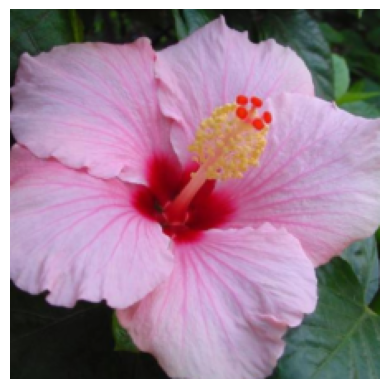

In [38]:
# Data Analysis: Processed data analysis

# understand processed data samples

# show a processed image

images, labels = next(iter(training_loader_data))   # gets one batch
images.shape

def denormalize(img_denorm):

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    img_denorm = img_denorm * std + mean
    img_denorm = img_denorm.clamp(0, 1)

    return img_denorm

processed_img_tensor = images[0].cpu()    # move image to cpu from gpu if needed for further operations
denormalized_img_tensor = denormalize(processed_img_tensor) # denormalize image first

# visualize processed image
plt.imshow(denormalized_img_tensor.permute(1, 2, 0))  # convert C,H,W -> H,W,C since PyTorch tensors are [C, H, W], but matplotlib expects [H, W, C]:
plt.axis("off")
plt.show()


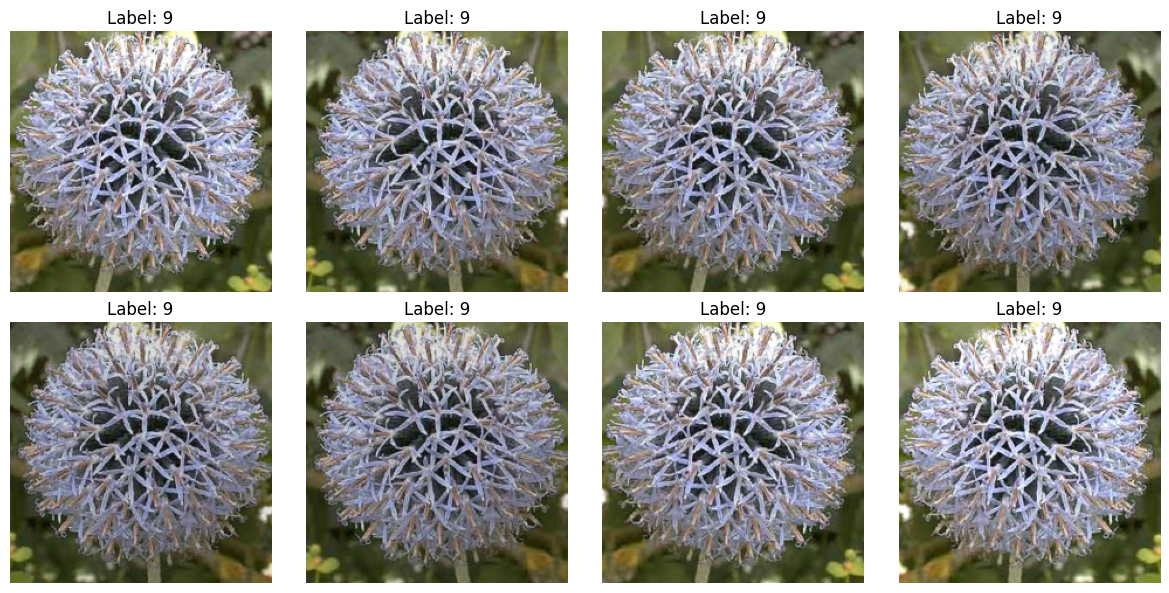

In [39]:

# Data Analysis: Processed data analysis

# understand processed data samples

# show the transformations or augmentations to a sample image

def visualize_augmentations(dataset, idx=0, num_versions=8):
    """ see what augmentations look like for a sample image """

    fix, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()

    for i in range(num_versions):
        img, label = dataset[idx]   # retrieve augmented version

        # denormalize for display
        img = denormalize(img)

        axes[i].imshow(img.permute(1, 2, 0))  # CHW to HWC
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


visualize_augmentations(dataset=train_dataset, idx=0, num_versions=8)


In [ ]:
# Training steps...

# dataset.print_stats() # if monitored dataset class is initialized instead, can call after each Training epoch to see trace of how data is accessed for better debugging